In [1]:
# %matplotlib widget
%matplotlib inline
import sympy as sp
import sympy.physics.mechanics as me
import sympy.plotting as splt
from typing import List
from sympy import sin, cos, pi, sqrt, acos, simplify, atan
import math
import matplotlib.pyplot as plt
import numpy as np
me.init_vprinting()

g, t = sp.symbols('g, t')

def homogeneous(rotation: sp.Matrix = sp.eye(3), translation: sp.Matrix = sp.zeros(3, 1)) -> sp.Matrix:
    return rotation.row_join(translation).col_join(sp.Matrix([[0, 0, 0, 1]]))

def dh(rotation, twist, displacement, offset):
    rotation_mat = sp.Matrix([
        [cos(rotation), -sin(rotation)*cos(twist),  sin(rotation)*sin(twist)],
        [sin(rotation), cos(rotation)*cos(twist),   -cos(rotation)*sin(twist)],
        [0,             sin(twist),                 cos(twist)],
    ])
    translation = sp.Matrix([
        [offset*cos(rotation)],
        [offset*sin(rotation)],
        [displacement],
    ])
    return rotation_mat, translation

def rotation(homogeneous: sp.Matrix):
    return homogeneous[:3, :3]

def translation(homogeneous: sp.Matrix):
    return homogeneous[:3, 3:]

def chained_transform(transforms: List[sp.Matrix]):
    transforms_chained = [homogeneous()]
    for transform in transforms:
        transforms_chained.append(transforms_chained[-1] * transform)
    return transforms_chained

def z_vecs(transforms: List[sp.Matrix]):
    transforms_chained = chained_transform(transforms)
    z_unit_vecs = []
    for transform in transforms_chained:
        z_unit_vecs.append(rotation(transform) * sp.Matrix([0, 0, 1]))
    return z_unit_vecs

def jacobian(transforms: List[sp.Matrix], joint_types: List[sp.Matrix], base_z: sp.Matrix = sp.Matrix([0, 0, 1])):
    transforms_chained = chained_transform(transforms)
    z_unit_vecs = z_vecs(transforms)
    
    assert len(transforms_chained) == len(z_unit_vecs)

    jacobian = sp.zeros(6, len(transforms))
    for i, (transform, joint_type) in enumerate(zip(transforms, joint_types)):
        if joint_type == 'revolute':
            jacobian[:3, i] = z_unit_vecs[i].cross(translation(transforms_chained[-1]) - translation(transforms_chained[i]))
            jacobian[3:, i] = z_unit_vecs[i]
        elif joint_type == 'prismatic':
            jacobian[:3, i] = z_unit_vecs[i]
            jacobian[3:, i] = sp.Matrix([[0], [0], [0]])

        # angular velocity

    return jacobian

def skew(v: sp.Matrix):
    return sp.Matrix([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0],
    ])

def compute_dynamics(all_joints: List[sp.Matrix], joint_types: List[str], q_dot: List[sp.Matrix], m: List[float], I: List[float], r_c: List[sp.Matrix]):
    J = jacobian(all_joints, joint_types)

    w = [sp.Matrix([0, 0, 0])]*(len(all_joints)+1) # joint linear velocities
    v = [sp.Matrix([0, 0, 0])]*(len(all_joints)+1) # joint angular velocities
    v_c = [sp.Matrix([0, 0, 0])]*(len(all_joints)+1) # joint CoM linear velocities
    T = [sp.Matrix([0])]*(len(all_joints)+1) # joint kinetic energy
    V = [sp.Matrix([0])]*(len(all_joints)+1) # joint potential energy

    chained_transforms = chained_transform(all_joints)
    # chained_translations = chained_translation(all_joints)
    # z = z_vecs(all_joints) # joint origins
    z = sp.Matrix([0, 0, 1]) # base z vector

    for i, joint, joint_type in zip(range(1, len(all_joints) + 1), all_joints, joint_types):
        # Compute angular velocity
        theta_dot = q_dot[i-1] if joint_type == 'revolute' else 0
        w[i] = rotation(joint).T * (w[i-1] + z*theta_dot)

        # Compute linear velocity
        d_dot = q_dot[i-1] if joint_type == 'prismatic' else 0
        r_i = (joint*origin)[:3, :]
        v[i] = rotation(joint).T * (v[i-1] + z*d_dot) + w[i].cross(r_i)

        # Compute CoM linear velocity
        v_c[i] = v[i] + w[i].cross(r_c[i][:3, :])

        # Compute kinetic energy
        T[i] = 0.5*m[i]*v_c[i].T*v_c[i] + 0.5*w[i].T*I[i]*w[i]

        # Compute potential energy
        p_ci = (chained_transforms[i]*r_c[i])[:3, :]
        V[i] = -m[i]*sp.Matrix([0, -g, 0]).T*p_ci
    
    return w, v, v_c, T, V



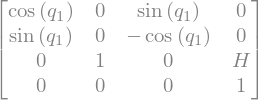

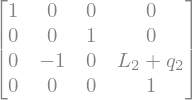

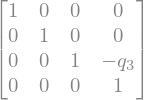

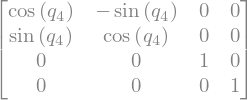

In [2]:
# robot parameters
H, L_2, L_1 = sp.symbols('H, L_2, L_1')
m_1, m_2, m_3, m_4, I_c1, I_c2, I_c3, I_c4 = sp.symbols('m_1, m_2, m_3, m_4, I_c1, I_c2, I_c3, I_c4')
# joint variables
q1, q2, q3, q4 = me.dynamicsymbols('q1, q2, q3, q4')
q1_dot, q2_dot, q3_dot, q4_dot = me.dynamicsymbols('q1, q2, q3, q4', 1)

# q_dot = sp.Matrix([q1_dot, q2_dot, q3_dot, q4_dot])
r_c = [0, sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1])]

# build dh
joint_1 = homogeneous(*dh(q1, pi/2, H, 0))
joint_2 = homogeneous(*dh(0, -pi/2, q2 + L_2, 0))
joint_3 = homogeneous(*dh(0, 0, -q3, 0))
joint_4 = homogeneous(*dh(q4, 0, 0, 0))
joint_types = ['revolute', 'prismatic', 'prismatic', 'revolute']
m = [0, m_1, m_2, m_3, m_4]
I = [0, I_c1, I_c2, I_c3, I_c4]
origin = sp.Matrix([0, 0, 0, 1])

# sanity checks
# display(joint_1*origin)
# display(joint_1*joint_2*origin)
# display(joint_1*joint_2*joint_3*origin)
# display(joint_1*joint_2*joint_3*joint_4*origin)
display(joint_1)
display(joint_2)
display(joint_3)
display(joint_4)

In [3]:
q1_traj = {
    t: [0, 5, 10],
    q1: [-180, -90, 0],
}
q4_traj = {
    t: [5, 10],
    q4: [0, -45],
}
q2_traj = {
    t: [5, 10],
    q2: [0, 1],
}

def poly(symbol: str, degree: int):
    N = degree + 1
    coeffs = [sp.symbols(f'{symbol}_{i}') for i in range(N)]
    return coeffs, sum([c*t**i for i, c in enumerate(coeffs)])

q1_coeffs, q1_expr = poly('a', 3)
q4_coeffs, q4_expr = poly('b', 5)
q2_coeffs, q2_expr = poly('c', 3)

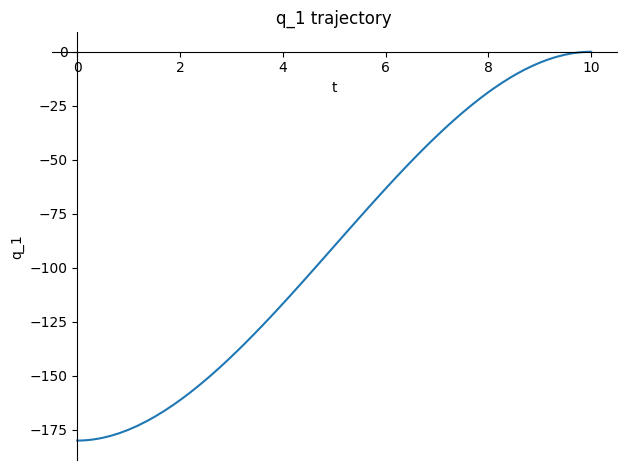

In [4]:
q1_sols = sp.solvers.polysys.solve_poly_system([
    *[sp.Eq(q1_expr.subs(t, t_), x) for t_, x in zip(q1_traj[t], q1_traj[q1])],

    sp.Eq(q1_expr.diff(t).subs(t, q1_traj[t][0]), 0),
    sp.Eq(q1_expr.diff(t).subs(t, q1_traj[t][-1]), 0),
], *q1_coeffs)[0]

q1_sol = q1_expr.subs({c: s for c, s in zip(q1_coeffs, q1_sols)}).evalf()
display(q1_sol)

q1_plot = sp.plotting.plot(q1_sol, (t, q1_traj[t][0], q1_traj[t][-1]), title='q_1 trajectory', xlabel='t', ylabel='q_1')
# for t_, x in zip(q1_traj[t], q1_traj[q1]):
#     plt.plot(t_, x, 'ro')

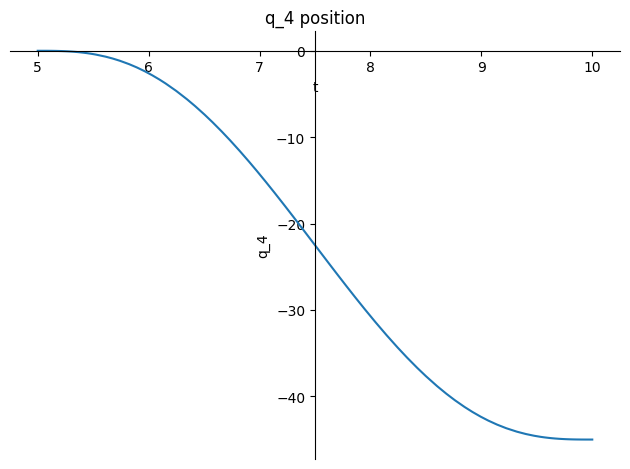

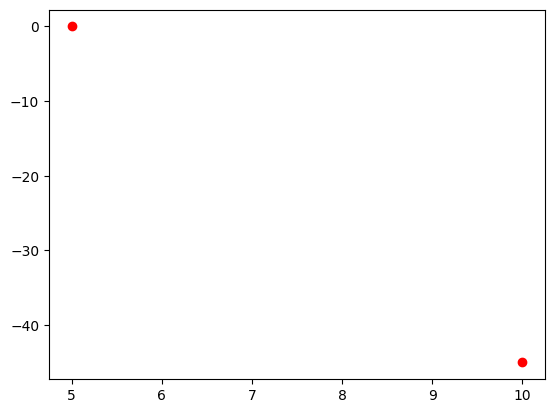

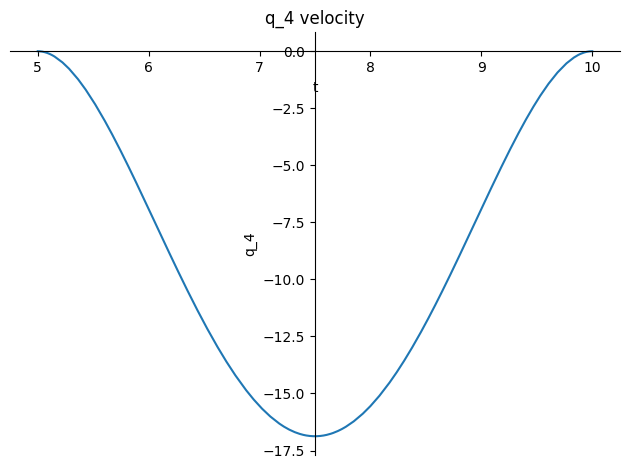

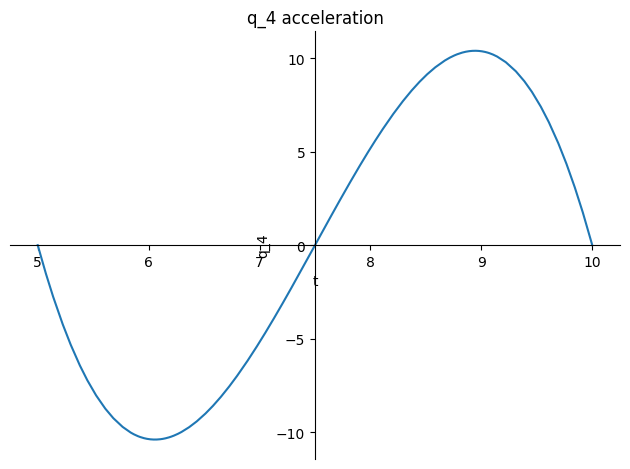

In [5]:
constraints = *[sp.Eq(q4_expr.subs(t, t_), x) for t_, x in zip(q4_traj[t], q4_traj[q4])],
display(constraints)
display(q4_coeffs)
display(q4_expr)
q4_sols = sp.solvers.polysys.solve_poly_system([
    # sp.Eq(q4_expr.subs(t, 5), 0),
    # sp.Eq(q4_expr.subs(t, 10), -45),
    *[sp.Eq(q4_expr.subs(t, t_), x) for t_, x in zip(q4_traj[t], q4_traj[q4])],

    sp.Eq(q4_expr.diff(t).subs(t, q4_traj[t][0]), 0),
    sp.Eq(q4_expr.diff(t).subs(t, q4_traj[t][-1]), 0),

    sp.Eq(q4_expr.diff(t).diff(t).subs(t, q4_traj[t][0]), 0),
    sp.Eq(q4_expr.diff(t).diff(t).subs(t, q4_traj[t][-1]), 0),
    # sp.Eq(q4_expr.diff(t).subs(t, 7.5), 1)
    # sp.Le(q4_expr.diff(t), 1),
    # sp.Le(q4_expr.diff(t).diff(t), 0.5),
], *q4_coeffs)[0]

q4_sol = q4_expr.subs({c: s for c, s in zip(q4_coeffs, q4_sols)}).evalf()
display(q4_sol)

q4_plot = sp.plotting.plot(q4_sol, (t, q4_traj[t][0], q4_traj[t][-1]), title='q_4 position', xlabel='t', ylabel='q_4')
for t_, x in zip(q4_traj[t], q4_traj[q4]):
    plt.plot(t_, x, 'ro')

sp.plotting.plot(q4_sol.diff(t), (t, q4_traj[t][0], q4_traj[t][-1]), title='q_4 velocity', xlabel='t', ylabel='q_4')

sp.plotting.plot(q4_sol.diff(t).diff(t), (t, q4_traj[t][0], q4_traj[t][-1]), title='q_4 acceleration', xlabel='t', ylabel='q_4')
# plt.plot([q4_traj[t][0], q4_traj[t][-1]], [0, 0], 'ro')


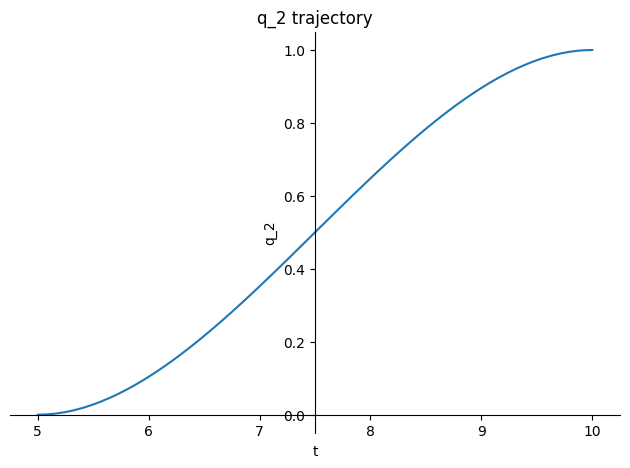

In [6]:
q2_sols = sp.solvers.polysys.solve_poly_system([
    *[sp.Eq(q2_expr.subs(t, t_), x) for t_, x in zip(q2_traj[t], q2_traj[q2])],

    sp.Eq(q2_expr.diff(t).subs(t, q2_traj[t][0]), 0),
    sp.Eq(q2_expr.diff(t).subs(t, q2_traj[t][-1]), 0),
], *q2_coeffs)[0]

q2_sol = q2_expr.subs({c: s for c, s in zip(q2_coeffs, q2_sols)}).evalf()
display(q2_sol)

q2_plot = sp.plotting.plot(q2_sol, (t, q2_traj[t][0], q2_traj[t][-1]), title='q_2 trajectory', xlabel='t', ylabel='q_2')
# for t_, x in zip(q2_traj[t], q2_traj[q1]):
#     plt.plot(t_, x, 'ro')

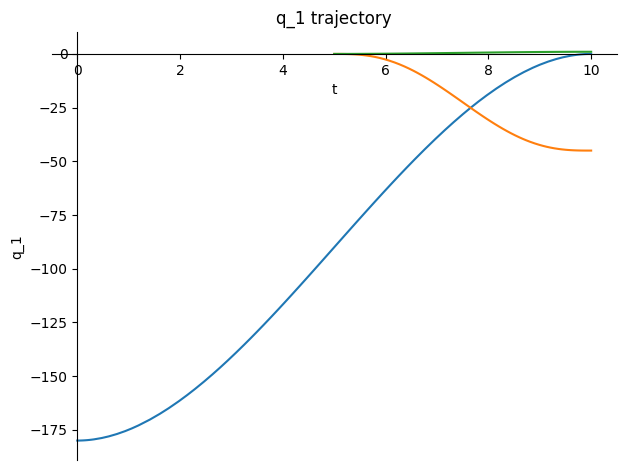

In [7]:
q1_plot.extend(q4_plot)
q1_plot.extend(q2_plot)
q1_plot.show()

In [8]:
w, v, v_c, T, V = compute_dynamics([joint_1, joint_2, joint_3, joint_4], joint_types, [q1_dot, q2_dot, q3_dot, q4_dot], m, I, r_c)
T_sum = sp.zeros(1)
V_sum = sp.zeros(1)
for t_i in T:
    T_sum += t_i
T = simplify(T_sum)
for v_i in V:
    V_sum += v_i
V = simplify(V_sum)
L = simplify(T-V)

torques = []
for i, (q, q_dot) in enumerate(zip([q1, q2, q3, q4], [q1_dot, q2_dot, q3_dot, q4_dot])):
    torque = simplify(L.diff(q_dot).diff(t) - L.diff(q)).evalf()
    torques.append(torque)
    display(torque)

# torque


In [9]:
display(q1_sol.diff(t))
display(q2_sol.diff(t))
display(q4_sol.diff(t))
display(q4_sol.diff(t).diff(t))